# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [6]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/128104/1272-128104-0000.flac"

In [7]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((69120,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [8]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [9]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 69120])

In [8]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

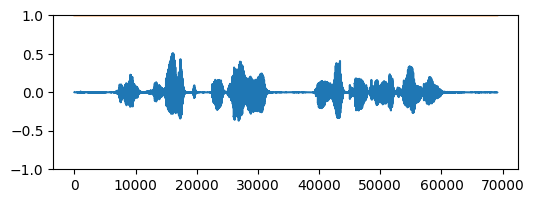

In [113]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [11]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [12]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [13]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [14]:
inputs = inputs2   # use the batch

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [5]:
from transformers import (
    SpeechT5Config, 
    SpeechT5Tokenizer,
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForSpeechToText, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [10]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)

In [11]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"

In [12]:
hf_model = SpeechT5ForSpeechToText.from_pretrained(model_checkpoint)

In [13]:
hf_model.eval()

SpeechT5ForSpeechToText(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithSpeechPrenet(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
   

In [21]:
# Loading should work OK for class `SpeechT5Model` too:
hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr were not used when initializing SpeechT5Model: ['speecht5.encoder.prenet.feature_encoder.conv_layers.6.conv.weight', 'speecht5.encoder.prenet.masked_spec_embed', 'speecht5.encoder.prenet.feature_encoder.conv_layers.3.conv.weight', 'speecht5.encoder.prenet.pos_sinusoidal_embed.weights', 'speecht5.encoder.prenet.feature_encoder.conv_layers.2.conv.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_v', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.layer_norm.weight', 'speecht5.encoder.prenet.feature_projection.projection.bias', 'text_decoder_postnet.lm_head.weight', 'speecht5.encoder.prenet.feature_encoder.conv_layers.5.conv.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.bias', 'speecht5.decoder.prenet.embed_positions.weights', 'speecht5.encoder.prenet.feature_projection.projection.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_g', '

In [34]:
hf_tokenizer = SpeechT5Tokenizer.from_pretrained(model_checkpoint)

In [35]:
hf_tokenizer

PreTrainedTokenizer(name_or_path='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr', vocab_size=79, model_max_len=450, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [36]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [37]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

tuple

In [38]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [39]:
# list(hf_outputs.keys())

In [49]:
# hf_outputs["extract_features"].shape

In [50]:
# hf_outputs["extract_features"]

In [51]:
# hf_outputs["hidden_states"].shape

In [52]:
# hf_outputs["hidden_states"]

In [53]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([1, 215, 768]), torch.Size([1, 215])]

In [54]:
hf_outputs[0]

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 7.7907, -6.4359,  5.6191,  ...,  0.0352,  3.1737,  0.4928],
         [-0.1691, -4.2425,  6.3816,  ..., -1.6755,  1.3843,  0.2407],
         [ 2.0105, -3.1966,  7.5800,  ..., -0.5673,  1.7153,  0.5722]]])

In [49]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[1]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [14]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [15]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [16]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [17]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [18]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [19]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [20]:
#list(checkpoint["model"].keys())

In [21]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [22]:
# orig_model.decoder.layers[0].encoder_attn

In [33]:
# list(checkpoint["cfg"].keys())

In [34]:
# checkpoint["cfg"]["task"]

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [23]:
source = inputs["input_values"]
source.shape

torch.Size([1, 69120])

In [24]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [25]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ..., False, False, False]])

In [26]:
# This doesn't work on the original model
#padding_mask = None

In [27]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [28]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [29]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([1, 215, 768]), torch.Size([1, 215]))

In [30]:
encoder_input

tensor([[[ 7.4147, -3.6930, 10.6119,  ...,  1.3639,  2.2972,  0.8101],
         [ 8.1118, -4.2742, 12.2622,  ...,  0.1729,  1.6734,  0.6476],
         [-2.8165,  2.4560, -1.3008,  ...,  0.9983, -0.4333,  2.5262],
         ...,
         [ 8.1539, -5.4359,  5.8689,  ...,  1.0349,  4.1734,  1.4926],
         [ 0.8112, -3.6817,  5.7369,  ..., -0.6757,  2.3840,  1.2404],
         [ 2.7066, -3.5683,  6.5834,  ...,  0.4324,  2.7151,  1.5720]]])

In [31]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [40]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(0.)

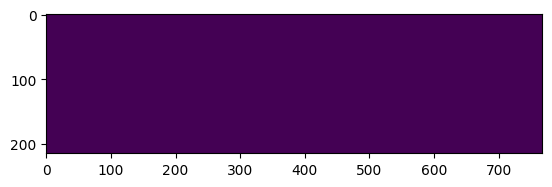

In [41]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

The line that is different is where the padding mask goes from 1 to 0; the original model handles this a little different than we do.

In [42]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [43]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [50]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [51]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [52]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([215, 1, 768])
encoder_padding_mask shape torch.Size([1, 215])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([215, 1, 81])


In [53]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]])

In [54]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.4632,  -9.6230,  -9.6073,  ...,  -9.5406,  -9.3881,  12.4264],
         [ -9.8169,  -9.9027,  -9.9673,  ...,  -9.8993,  -9.7949,  13.0776],
         [-10.9712, -11.0219, -11.0252,  ..., -11.0365, -10.9394,  14.6879],
         ...,
         [ -8.2366,  -8.3445,  -8.3155,  ...,  -8.4186,  -8.0964,  10.4814],
         [ -8.7586,  -8.9771,  -8.8052,  ...,  -8.8178,  -8.5105,  11.1125],
         [ -9.6384, -10.0383,  -9.7550,  ...,  -9.7551,  -9.3112,  11.0622]]])

In [55]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [56]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=hf_encoder_attention_mask,
#          input_values=inputs.input_values,
#          attention_mask=inputs.attention_mask,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [57]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]]), hidden_states=None, attentions=None)

In [58]:
list(hf_outputs.keys())

['last_hidden_state']

In [59]:
hf_outputs["last_hidden_state"].shape

torch.Size([1, 215, 768])

In [60]:
hf_outputs["last_hidden_state"]

tensor([[[-0.3412, -0.1983, -0.5504,  ...,  0.3371, -0.7611,  0.2468],
         [-0.3532, -0.1819, -0.6027,  ...,  0.2886, -0.8502,  0.1505],
         [-0.4093, -0.1701, -0.6913,  ...,  0.2886, -0.7586, -0.0191],
         ...,
         [ 0.2191,  0.1308, -0.2119,  ...,  0.2059, -0.7364,  0.2486],
         [ 0.0395,  0.0048, -0.3112,  ...,  0.1692, -0.7535,  0.2188],
         [-0.0338, -0.1440, -0.3480,  ...,  0.2844, -0.7159,  0.1947]]])

In [61]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(0.)

## Verify CTC model

This model only needs the encoder portion.

This uses the same checkpoint as before: `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Run the following to convert, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task ctc \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [59]:
# hf_model_ctc = SpeechT5ForCTC(config)

In [62]:
model_checkpoint_ctc = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc"
hf_model_ctc = SpeechT5ForCTC.from_pretrained(model_checkpoint_ctc)

In [70]:
# This should also work:
hf_model_ctc_naked = SpeechT5Model.from_pretrained(model_checkpoint_ctc)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc were not used when initializing SpeechT5Model: ['speecht5.encoder.prenet.feature_encoder.conv_layers.6.conv.weight', 'speecht5.encoder.prenet.masked_spec_embed', 'speecht5.encoder.prenet.feature_encoder.conv_layers.3.conv.weight', 'speecht5.encoder.prenet.pos_sinusoidal_embed.weights', 'speecht5.encoder.prenet.feature_encoder.conv_layers.2.conv.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_v', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.layer_norm.weight', 'speecht5.encoder.prenet.feature_projection.projection.bias', 'lm_head.bias', 'speecht5.encoder.prenet.feature_encoder.conv_layers.5.conv.weight', 'lm_head.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.bias', 'speecht5.encoder.prenet.feature_projection.projection.weight', 'speecht5.encoder.prenet.pos_conv_embed.conv.weight_g', 'speecht5.encoder.prenet.feature_encoder.conv_layers.0.co

In [79]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model_ctc(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model_ctc(input_values=inputs["input_values"])

type(hf_outputs)

transformers.modeling_outputs.CausalLMOutput

In [80]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(0.)

In [81]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [82]:
probs

tensor([[80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4, 46, 80, 80, 16, 80, 80, 12, 12,  6,  6, 80, 80, 80, 80,
         80,  4,  4,  4,  6,  6, 11, 11, 13, 13, 13, 80, 16, 16, 80, 80, 80, 80,
         12, 12,  6,  6, 80, 80, 80, 80, 80, 80, 80, 80,  4,  4,  4, 80, 80,  7,
          9, 14, 14,  4,  4, 80, 24, 80, 80, 80, 80,  5, 13, 13, 80, 80, 13, 13,
         80, 22, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4, 80,  7,  7,  9, 14,
         14, 80,  4,  4,  4, 27, 80, 80, 10, 80, 17, 17,  6,  6,  6,  8, 13, 13,
         13, 22, 22, 80, 80,  4,  4,  6,  8,  8, 80,  4,  6,  6, 11,  5,  5,  4,
         12, 12, 80,  6,  6, 13, 13, 80, 80,  8, 80,  9,  9, 80, 21, 21, 80, 80,
          5, 13, 13, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
         80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]])

In [68]:
# print(tgt_dict.string(probs[0]))

In [83]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))
    print("")

                jusstt   tthhrrruusstt   andd  perrrry       aandd   vicctttorrryy  too tthee ssttrronnggerr



In [84]:
hf_tokenizer_ctc = SpeechT5Tokenizer.from_pretrained(model_checkpoint_ctc)
hf_tokenizer_ctc

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'SpeechT5CTCTokenizer'. 
The class this function is called from is 'SpeechT5Tokenizer'.


PreTrainedTokenizer(name_or_path='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc', vocab_size=79, model_max_len=450, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [87]:
#hf_tokenizer_ctc.decode(probs[0])

In [86]:
hf_tokenizer_ctc.batch_decode(probs)

['<ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> j <ctc_blank> <ctc_blank> u <ctc_blank> <ctc_blank> sstt <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> tthhrrr <ctc_blank> uu <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> sstt <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank>  <ctc_blank> <ctc_blank> andd <ctc_blank> p <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> err <ctc_blank> <ctc_blank> rr <ctc_blank> y <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank> <ctc_blank>  <ctc_blank> aandd <ctc_blank> v <ctc_blank> <ctc_blank> i <ctc_blank> cctttorrryy <ctc_blank> <ctc_blank> too <ctc_blank> tthee ss <ctc_blank> ttrr <ctc_blank> <ctc_blank> o <ctc_blank> nn <ctc_blank> gg <ctc_blank> <ctc_blank> err <ct

In [88]:
hf_tokenizer_ctc = SpeechT5CTCTokenizer.from_pretrained(model_checkpoint_ctc)

In [111]:
from transformers import AutoTokenizer
hf_tokenizer_ctc = AutoTokenizer.from_pretrained(model_checkpoint_ctc)
type(hf_tokenizer_ctc)

transformers.models.speecht5.tokenization_speecht5.SpeechT5CTCTokenizer

In [112]:
hf_tokenizer_ctc.convert_tokens_to_string(
    hf_tokenizer_ctc2.convert_ids_to_tokens(probs[0]),
    #spaces_between_special_tokens=True,
)

'just thrust and perry and victory to the stronger'

In [113]:
hf_tokenizer_ctc.decode(probs[0])

'just thrust and perry and victory to the stronger'

In [114]:
hf_tokenizer_ctc.batch_decode(probs)

['just thrust and perry and victory to the stronger']

Calculate loss:

In [109]:
with torch.no_grad():
     hf_outputs = hf_model_ctc(
         **inputs, 
         labels=torch.tensor(
           [[ 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13, ]]
         ),
         output_hidden_states=True,
         return_dict=True,
     )

In [110]:
hf_outputs.loss

tensor(1208.0262)

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [84]:
batch_size = inputs.input_values.size(0)
beam_size = 5

In [85]:
tokens = torch.tensor([2, 4, 46, 16, 12, 16] * beam_size * batch_size).reshape(beam_size * batch_size, -1)
tokens.shape

torch.Size([10, 6])

In [86]:
# This one has padding (token_id = 1)
# The results will be different with the HF implementation because
# we don't set the attention_mask to 0 for padding tokens
# tokens = torch.tensor([2, 4, 46, 16, 1, 12] * beam_size * batch_size).reshape(beam_size * batch_size, -1)

In [87]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state=None)

In [88]:
# This returns a sequence length of 1
# with torch.no_grad():
#     prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state={})

In [89]:
# Note: misleading name; these are not the actual tokens but their embeddings!
prev_output_tokens.shape

torch.Size([10, 6, 768])

In [90]:
tgt_mask

In [91]:
incremental_state

In [92]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_ids=tokens,
#          attention_mask=hf_encoder_attention_mask,
#          attention_mask=inputs.attention_mask,
#          past_key_values=[(torch.ones(5, 1, 1), torch.ones(5, 1, 1))],
     )

type(hf_outputs)

tuple

In [93]:
token_embeds_hf, decoder_attention_mask = hf_outputs

In [94]:
token_embeds_hf.shape

torch.Size([10, 6, 768])

In [95]:
torch.max(torch.abs(prev_output_tokens - token_embeds_hf))

tensor(0.)

In [96]:
decoder_attention_mask

## Verify Transformer decoder output

In [97]:
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [98]:
prev_output_tokens

tensor([[[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
  

In [99]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [100]:
decoder_output.shape

torch.Size([10, 6, 768])

In [101]:
decoder_output

tensor([[[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
  

In [102]:
#[x.shape for x in extra["attn"]]

In [103]:
#[x.shape for x in extra["inner_states"]]

In [104]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_outs["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [105]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [106]:
hf_outputs["last_hidden_state"].shape

torch.Size([10, 6, 768])

In [107]:
hf_outputs["last_hidden_state"]

tensor([[[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
  

In [108]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(1.6689e-06)

## Verify text decoder postnet output

In [109]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [110]:
lprobs.shape

torch.Size([10, 6, 81])

In [111]:
lprobs[0]

tensor([[-2.4168e+01, -2.2556e+01,  5.4097e-01, -2.2586e+01,  1.7349e+01,
          4.6760e-02,  6.2041e-01, -9.4606e-01, -4.4315e-01, -1.8812e+00,
         -3.9952e-01,  2.1893e-01,  3.9134e-01, -1.3906e+00, -2.2705e+00,
         -1.5500e+00, -1.0440e+00, -2.6232e+00, -7.7046e-01, -4.0442e-02,
          1.1401e+00,  2.4883e-01, -3.7950e+00, -2.2715e+01, -8.6929e-01,
          6.3732e-01, -2.2659e+01, -2.8817e+00, -3.3690e+00, -2.2606e+01,
         -2.2637e+01,  9.3877e-02, -2.2744e+01, -2.2613e+01, -2.2609e+01,
         -2.2670e+01, -2.2651e+01, -5.3913e+00, -2.2602e+01, -2.2722e+01,
         -2.2586e+01, -2.2674e+01, -2.2655e+01, -2.2676e+01, -2.2658e+01,
         -2.4368e+00, -2.3410e+00, -2.2580e+01, -2.2609e+01, -2.2735e+01,
         -2.2613e+01, -2.2698e+01, -2.2605e+01, -2.2590e+01, -2.2633e+01,
         -2.2558e+01, -2.2639e+01, -6.2336e+00, -2.2628e+01, -2.2604e+01,
         -2.2654e+01, -2.2722e+01, -2.2647e+01, -2.2622e+01, -2.2642e+01,
         -2.2666e+01, -2.2624e+01, -2.

In [112]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [113]:
lprobs_hf.shape

torch.Size([10, 6, 81])

In [114]:
lprobs_hf[0]

tensor([[-2.4168e+01, -2.2556e+01,  5.4097e-01, -2.2586e+01,  1.7349e+01,
          4.6760e-02,  6.2041e-01, -9.4606e-01, -4.4315e-01, -1.8812e+00,
         -3.9952e-01,  2.1893e-01,  3.9134e-01, -1.3906e+00, -2.2705e+00,
         -1.5500e+00, -1.0440e+00, -2.6232e+00, -7.7046e-01, -4.0442e-02,
          1.1401e+00,  2.4883e-01, -3.7950e+00, -2.2715e+01, -8.6929e-01,
          6.3732e-01, -2.2659e+01, -2.8817e+00, -3.3690e+00, -2.2606e+01,
         -2.2637e+01,  9.3877e-02, -2.2744e+01, -2.2613e+01, -2.2609e+01,
         -2.2670e+01, -2.2651e+01, -5.3913e+00, -2.2602e+01, -2.2722e+01,
         -2.2586e+01, -2.2674e+01, -2.2655e+01, -2.2676e+01, -2.2658e+01,
         -2.4368e+00, -2.3410e+00, -2.2580e+01, -2.2609e+01, -2.2735e+01,
         -2.2613e+01, -2.2698e+01, -2.2605e+01, -2.2590e+01, -2.2633e+01,
         -2.2558e+01, -2.2639e+01, -6.2336e+00, -2.2628e+01, -2.2604e+01,
         -2.2654e+01, -2.2722e+01, -2.2647e+01, -2.2622e+01, -2.2642e+01,
         -2.2666e+01, -2.2624e+01, -2.

In [115]:
torch.max(torch.abs(lprobs - lprobs_hf))

tensor(0.)

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [120]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[3, 4, 5]]),
         #decoder_input_ids=torch.tensor([[3, 4, 5], [2, 2, 2]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [121]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [122]:
hf_outputs["logits"].shape

torch.Size([1, 3, 81])

Also calculate loss:

In [123]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [124]:
hf_outputs["logits"].shape

torch.Size([1, 7, 81])

In [125]:
hf_outputs["loss"]

tensor(6.1307e-06)

Generator loop:

In [126]:
inputs.input_values.shape

torch.Size([1, 93680])

In [127]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [128]:
hf_outputs.shape

torch.Size([1, 92])

In [129]:
hf_outputs

tensor([[ 2,  4, 18, 10, 12,  6,  5, 13,  4, 45, 16, 10, 15,  6,  5, 13,  4, 10,
         12,  4,  6, 11,  5,  4,  7, 24,  8, 12,  6, 15,  5,  4,  8, 19,  4,  6,
         11,  5,  4, 18, 10, 14, 14, 15,  5,  4, 17, 15,  7, 12, 12,  5, 12,  4,
          7,  9, 14,  4, 20,  5,  4,  7, 13,  5,  4, 21, 15,  7, 14,  4,  6,  8,
          4, 20,  5, 15, 17,  8, 18,  5,  4, 11, 10, 12,  4, 21,  8, 12, 24,  5,
         15,  2]])

In [130]:
for i in range(hf_outputs.shape[0]):
    print(tgt_dict.string(hf_outputs[i]))
    print(tokenizer.decode(tgt_dict.string(hf_outputs[i])))
    print("")

▁ m i s t e r ▁ q u i l t e r ▁ i s ▁ t h e ▁ a p o s t l e ▁ o f ▁ t h e ▁ m i d d l e ▁ c l a s s e s ▁ a n d ▁ w e ▁ a r e ▁ g l a d ▁ t o ▁ w e l c o m e ▁ h i s ▁ g o s p e l
mister quilter is the apostle of the middle classes and we are glad to welcome his gospel



In [131]:
[tgt_dict[x] for x in range(5)]

['<s>', '<pad>', '</s>', '<unk>', '▁']

In [132]:
hf_tokenizer.batch_decode(hf_outputs)

['</s>mister quilter is the apostle of the middle classes and we are glad to welcome his gospel</s>']

For comparison, Speech2Text:

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

s2t_model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
s2t_processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

In [222]:
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

inputs = s2t_processor(
    ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
)
input_features = inputs.input_features
input_features.shape

/Users/matthijs/anaconda3/envs/t5/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


torch.Size([1, 584, 80])

In [223]:
# test batch
# input_features = torch.tile(input_features, dims=(2, 1, 1))
# input_features.shape

torch.Size([2, 584, 80])

In [224]:
generated_ids = s2t_model.generate(inputs=input_features)

transcription = s2t_processor.batch_decode(generated_ids)[0]
transcription

#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1
/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the 

'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

In [255]:
from transformers import Speech2TextModel

s2t_model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*** has_prefix_module True expects_prefix_module False
*** remove_prefix_from_model False add_prefix_to_model True


Test other methods:

In [30]:
# BART, Speech2Text, Wav2Vec2 don't have pruning
#hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

In [108]:
hf_model.get_input_embeddings()

Embedding(81, 768, padding_idx=1)

In [109]:
hf_model.get_output_embeddings()

Linear(in_features=768, out_features=81, bias=False)

In [25]:
hf_model.resize_token_embeddings(100)

Embedding(100, 768)

In [26]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [117]:
hf_model.freeze_feature_encoder()

In [118]:
hf_model_ctc.freeze_feature_encoder()

In [119]:
hf_model_naked.freeze_feature_encoder()